In [17]:
from neural_denoiser import BinDenoiser
from negbin import RecordGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [18]:
maxbins = None
batch = 16
denoiser = BinDenoiser(nblocks=10, ksize=7, filters=32)
inputs = tf.keras.Input(shape=(maxbins, 1), batch_size=batch)
outputs = denoiser(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(16, None, 1)]           0         
_________________________________________________________________
bin_denoiser_2 (BinDenoiser) (16, None, 1)             9865      
Total params: 9,865
Trainable params: 9,865
Non-trainable params: 0
_________________________________________________________________


In [79]:
def tv_reg(yhat):
    x = tf.expand_dims(yhat, axis=-1)  # batch x nbins x 1
    tv = tf.image.total_variation(x)  # batch
    reg = 0.00005 * tf.reduce_sum(tv)
    return reg


def my_loss(y, yhat):
    err = y - yhat
    err = tf.reduce_sum(err**2, axis=1)
    err = tf.reduce_mean(err)
    loss = err  + tv_reg(yhat)
    return loss 


model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-3,
                clipnorm=1.0),
              loss=my_loss)



In [80]:
def plot_test_case():
    data = generator.generate()
    h = np.arange(data['n_bins'])
    x = np.array(data['counts'], dtype=float)
    x /= x.sum()
    y = data['signal_normalized']
    xinput = np.expand_dims(x, -1)
    xinput = np.expand_dims(xinput, 0)
    yhat = np.squeeze(model.predict(xinput))
    plt.bar(h, x, width=1)
    plt.plot(h, yhat, c="red")
    plt.plot(h, y, c="blue")
    return x, y, yhat



sim 0/50000, loss: 0.0107, losses_av: 0.0107, tv_loss: 0.00027
sim 100/50000, loss: 0.0033, losses_av: 0.0073, tv_loss: 0.00010
sim 200/50000, loss: 0.0077, losses_av: 0.0067, tv_loss: 0.00017
W1209 10:43:08.664110  3240 def_function.py:474] 5 out of the last 5 calls to <function _make_execution_function.<locals>.distributed_function at 0x000001620F02E9D8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
sim 300/50000, loss: 0.0075, losses_av: 0.0063, tv_loss: 0.00011
W1209 10:43:58.874126  3240 def_function.py:474] 6 out of the last 6 calls to <function _make_execution_function.<locals>.d

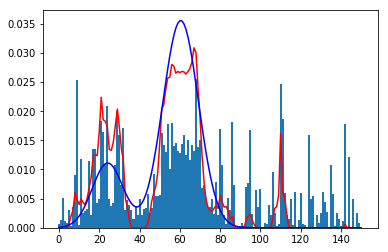

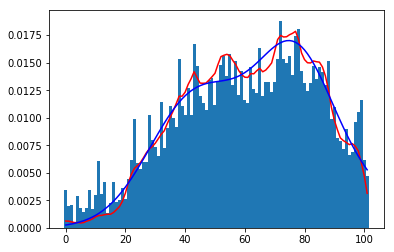

In [81]:
generator = RecordGenerator()
nsims = 50000
X = []
Y = []
losses = []
losses_av = []
lamb = 0.01
losses_av = []

for sim in range(nsims):
    n_bins = np.random.randint(10, 501)
    Xbatch = []
    Ybatch = []
    for _ in range(batch):
        data = generator.generate(n_bins=n_bins)
        x = np.array(data['counts'], dtype=float)
        x /= x.sum()
        Xbatch.append(x)
        y = data['signal_normalized']
        Ybatch.append(y)
    Xbatch = np.expand_dims(np.stack(Xbatch, 0), -1)
    Ybatch = np.expand_dims(np.stack(Ybatch, 0), -1)
    loss = model.train_on_batch(Xbatch, Ybatch)
    losses.append(float(loss))

    if sim == 0:
        losses_av.append(float(loss))
    else:
        L = lamb * losses[-1] + (1.0 - lamb) * losses_av[-1]
        losses_av.append(L)
    
    if sim % 100 == 0:
        tv_loss = tv_reg(tf.constant(model.predict(Xbatch)))
        print(f"sim {sim}/{nsims}, loss: {losses[-1]:.4f}, ", end="")
        print(f"losses_av: {losses_av[-1]:.4f}, tv_loss: {tv_loss:.5f}")
    
    if sim % 500 == 0:
        plot_test_case()
        plt.show()
        model.save_weights("tmp.h5")




In [0]:

plt.plot(losses)
plt.plot(losses_av, c="red")



In [0]:
x, y, yhat = plot_test_case()

In [0]:

plt.scatter(yhat, y)
plt.xlabel("prediction")
plt.ylabel("truth")
M = max(max(yhat), max(y))
plt.plot([0, M], [0, M], c="red")

